# Final Project - Basics of deep learning

---
<br>

### Name and ID:
Student 1: Dor Bismut - 318551504
<br>
Student 2: Guy Moshe Forer - 318465754

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/20733/logos/header.png?t=2020-05-14-08-44-45">

# Utils

## Import Libraries

In [1]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import load_img
from keras.preprocessing import image
from tensorflow.keras import layers
from sklearn.neighbors import NearestNeighbors
from PIL import Image
from tensorflow.keras.applications import VGG16
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import joblib
import seaborn as sns
import sklearn.metrics as metrics
from google.colab import drive
from google.colab import files

!pip install -U --no-cache-dir gdown --pre
!gdown --id 1m1QeEG7w179G13bck7jJzu4b-QJWO52s

## Dataset
Cars196 - 196 different classes of vehicles

### Download Data

In [2]:
%%script echo skipped
%%capture
[train_data, valid_data, test_data], info = tfds.load('Cars196', split=['train+test[:70%]', 'train+test[70%:85%]', 'train+test[85%:100%]'], as_supervised=True, with_info=True, shuffle_files=True)


###Dictionary of the labels - maps between the label (int) number and the vehicle model (str)

In [19]:
%%script echo skipped
label_dic = pd.read_csv('/content/labels_dic.csv', header=None, dtype={0: str}).set_index(0).squeeze().to_dict()

#General Definitions

In [ ]:
%%script echo skipped
num_classes = 196

#Image Retrieval Configuration


###Define the image preprocessing function

In [ ]:
%%script echo skipped
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.
    label = tf.one_hot(label, depth=num_classes)
    return image, label

###Prepare the datasets for training and validation and get the labels for the train set and test set


In [ ]:
%%script echo skipped
train_dataset_preprocessed = train_data.map(preprocess_image).batch(32).prefetch(1)
valid_dataset_preprocessed = valid_data.map(preprocess_image).batch(32).prefetch(1)
test_dataset_preprocessed = test_data.map(preprocess_image).batch(32).prefetch(1)

train_labels = np.array([label.numpy() for _, label in train_dataset_preprocessed])
test_labels = np.array([label.numpy() for _, label in test_dataset_preprocessed])


<ipython-input-19-880b637f9b29>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_labels = np.array([label.numpy() for _, label in train_dataset_preprocessed])
<ipython-input-19-880b637f9b29>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_labels = np.array([label.numpy() for _, label in test_dataset_preprocessed])


###Define the function to extract embeddings from the model


In [ ]:
%%script echo skipped
def extract_embeddings(model, dataset):
    embeddings = []
    labels = []
    for image, label in dataset:
        embedding = model.predict(image, verbose=0)
        embeddings.append(embedding)
        labels.append(label)
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    return embeddings, labels


###Define the function to train the KNN model


In [ ]:
%%script echo skipped
def train_knn_model(embeddings, train_labels):
    knn_model = KNeighborsClassifier(5)
    knn_model.fit(embeddings, train_labels)
    return knn_model

In [ ]:
%%script echo skipped
def plot_experiment_results_knn(history, knn_model, test_dataset, test_embeddings, test_labels):
    # Plot training and validation accuracy over epochs
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training and validation loss over epochs
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    test_predictions = knn_model.predict(test_embeddings)
    if len(test_predictions.shape) == 1 or test_predictions.shape[1] == 1:
        test_predictions = np.argmax(test_predictions, axis=1)
    else:
        test_predictions = (test_predictions >= 0.5).astype(int)

    # Compute and print different evaluation metrics
    f1_score = metrics.f1_score(test_labels, test_predictions, average='weighted')
    recall = metrics.recall_score(test_labels, test_predictions, average='weighted')
    precision = metrics.precision_score(test_labels, test_predictions, average='weighted')
    accuracy = metrics.accuracy_score(test_labels, test_predictions)
    print('Evaluation Metrics:')
    print(f'F1 Score: {f1_score:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Accuracy: {accuracy:.4f}')

    print('\nClassification Report\n')
    print(classification_report(test_labels, test_predictions))

In [ ]:
%%script echo skipped
def compare_experiments_image_retrieval(knn_model1, embeddings1, labels1, knn_model2, embeddings2, labels2, knn_model3, embeddings3, labels3):
    # Compute evaluation metrics for each experiment
    f1_scores = []
    recalls = []
    precisions = []
    accuracies = []

    for knn_model, embeddings, labels in [(knn_model1, embeddings1, labels1), (knn_model2, embeddings2, labels2), (knn_model3, embeddings3, labels3)]:
        # Use the KNN model to retrieve the closest images
        test_predictions = knn_model.predict(embeddings)
        if len(test_predictions.shape) == 1 or test_predictions.shape[1] == 1:
            test_predictions = np.argmax(test_predictions, axis=1)
        else:
            test_predictions = (test_predictions >= 0.5).astype(int)

        # Compute and print different evaluation metrics
        f1_scores.append(metrics.f1_score(labels, test_predictions, average='weighted'))
        recalls.append(metrics.recall_score(labels, test_predictions, average='weighted'))
        precisions.append(metrics.precision_score(labels, test_predictions, average='weighted'))
        accuracies.append(metrics.accuracy_score(labels, test_predictions))

    # Plot evaluation metrics
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    ax[0][0].bar(['Experiment 1', 'Experiment 2', 'Experiment 3'], f1_scores)
    ax[0][0].set_title('F1 Score')
    ax[0][1].bar(['Experiment 1', 'Experiment 2', 'Experiment 3'], recalls)
    ax[0][1].set_title('Recall')
    ax[1][0].bar(['Experiment 1', 'Experiment 2', 'Experiment 3'], precisions)
    ax[1][0].set_title('Precision')
    ax[1][1].bar(['Experiment 1', 'Experiment 2', 'Experiment 3'], accuracies)
    ax[1][1].set_title('Accuracy')
    plt.tight_layout()
    plt.show()


##Experiment1


*   Description: This experiment uses a pre-trained VGG16 model with additional layers for image retrieval. The pre-trained layers are frozen and only the additional layers are trained.
*   Hyper parameters: Adam optimizer, default learning rate, 100 epochs, categorical cross-entropy loss.
*   Architecture: The pre-trained VGG16 model with added global average pooling layer and a fully connected layer.
*   Why we chose this model: VGG16 is a widely used pre-trained model for image classification tasks and has shown good performance on various datasets. By adding additional layers and training only those layers, we can leverage the learned features of VGG16 while also fine-tuning the model to our specific task.


###Load the pretrained VGG16 model

In [ ]:
%%script echo skipped
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 4s 0us/step


###Add a global average pooling layer and a fully connected layer

In [ ]:
%%script echo skipped
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

###Create the model

In [ ]:
%%script echo skipped
model_experiment1 = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

###Freeze the pre-trained layers

In [ ]:
%%script echo skipped
for layer in base_model.layers:
    layer.trainable = False

###Compile the model

In [ ]:
%%script echo skipped
model_experiment1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

###Train the model

In [ ]:
%%script echo skipped
history = model_experiment1.fit(train_dataset_preprocessed, epochs=100, validation_data=valid_dataset_preprocessed)

Epoch 1/100
431/431 [==============================] - 101s 208ms/step - loss: 5.1921 - accuracy: 0.0171 - val_loss: 4.9146 - val_accuracy: 0.0447
Epoch 2/100
431/431 [==============================] - 94s 217ms/step - loss: 4.6163 - accuracy: 0.0606 - val_loss: 4.3062 - val_accuracy: 0.0911
Epoch 3/100
431/431 [==============================] - 99s 229ms/step - loss: 4.1006 - accuracy: 0.1137 - val_loss: 3.8906 - val_accuracy: 0.1431
Epoch 4/100
431/431 [==============================] - 95s 221ms/step - loss: 3.7477 - accuracy: 0.1627 - val_loss: 3.5955 - val_accuracy: 0.1825
Epoch 5/100
431/431 [==============================] - 99s 230ms/step - loss: 3.4891 - accuracy: 0.2059 - val_loss: 3.3695 - val_accuracy: 0.2235
Epoch 6/100
431/431 [==============================] - 99s 231ms/step - loss: 3.2885 - accuracy: 0.2396 - val_loss: 3.1974 - val_accuracy: 0.2543
Epoch 7/100
431/431 [==============================] - 100s 232ms/step - loss: 3.1204 - accuracy: 0.2697 - val_loss: 3.0404

###Extract embeddings from the model

In [ ]:
%%script echo skipped
train_embeddings1, train_label_embeddings1 = extract_embeddings(model_experiment1, train_dataset_preprocessed)
test_embeddings1, test_label_embeddings1 = extract_embeddings(model_experiment1, test_dataset_preprocessed)

###Train the KNN model

In [ ]:
%%script echo skipped
knn_model_experiment1 = train_knn_model(train_embeddings1, train_label_embeddings1)

###Evaluate the model on the test set

In [ ]:
%%script echo skipped
test_loss, test_accuracy = model_experiment1.evaluate(test_dataset_preprocessed)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

293/293 [==============================] - 40s 138ms/step - loss: 0.8658 - accuracy: 0.7990
Test loss: 0.8657734394073486
Test accuracy: 0.7990374565124512


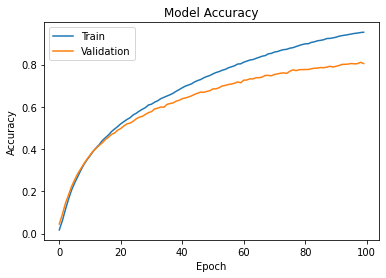

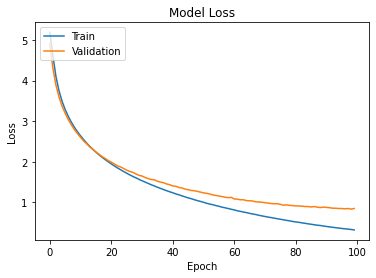

Evaluation Metrics:
F1 Score: 0.8390
Recall: 0.8021
Precision: 0.8911
Accuracy: 0.8021

Classification Report

              precision    recall  f1-score   support

           0       0.98      0.90      0.94        50
           1       0.86      0.49      0.62        37
           2       0.86      0.89      0.88        47
           3       0.90      0.71      0.80        49
           4       0.93      0.95      0.94        43
           5       0.96      0.88      0.92        50
           6       0.94      0.83      0.88        41
           7       0.87      0.63      0.73        54
           8       0.80      0.71      0.75        45
           9       0.82      0.85      0.84        39
          10       0.96      0.51      0.67        47
          11       0.88      0.83      0.85        46
          12       0.79      0.58      0.67        45
          13       0.74      0.78      0.76        51
          14       0.87      0.77      0.82        52
          15       0.75 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
%%script echo skipped
plot_experiment_results_knn(history, knn_model_experiment1, test_dataset_preprocessed, test_embeddings1, test_label_embeddings1)

##Experiment2
*   Description of the experiment: The second experiment uses MobileNetV2 pre-trained model for feature extraction with additional layers for image retrieval. The weights of the base model are frozen except for the added layers which are trained.
*   Hyper parameters: Adam optimizer, learning rate = 0.0001, categorical cross-entropy loss, 70 epochs.
*   Architecture: The base MobileNetV2 model with added global average pooling layer, a dropout layer, and a fully connected layer.
*   Why we chose this model: MobileNetV2 is a lightweight pre-trained model that has shown good performance on image classification tasks. The added dropout layer can help prevent overfitting.

###Load the pre-trained base model

In [ ]:
%%script echo skipped
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

9406464/9406464 [==============================] - 0s 0us/step


###Freeze the weights of the base model

In [ ]:
%%script echo skipped
base_model.trainable = False

###Add new layers on top of the base model

In [ ]:
%%script echo skipped
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(196, activation='softmax')(x)

###Create the final model

In [ ]:
%%script echo skipped
model_experiment2 = Model(inputs=base_model.input, outputs=predictions)

###Compile the model

In [ ]:
%%script echo skipped
model_experiment2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

###Train the model

In [ ]:
%%script echo skipped
history = model_experiment2.fit(
    train_dataset_preprocessed,
    epochs=70,
    validation_data=valid_dataset_preprocessed
)

Epoch 1/70
431/431 [==============================] - 62s 134ms/step - loss: 5.1075 - accuracy: 0.0233 - val_loss: 4.5751 - val_accuracy: 0.0933
Epoch 2/70
431/431 [==============================] - 59s 137ms/step - loss: 4.4324 - accuracy: 0.0784 - val_loss: 3.8674 - val_accuracy: 0.2302
Epoch 3/70
431/431 [==============================] - 69s 161ms/step - loss: 3.9405 - accuracy: 0.1321 - val_loss: 3.4008 - val_accuracy: 0.3172
Epoch 4/70
431/431 [==============================] - 57s 132ms/step - loss: 3.5780 - accuracy: 0.1808 - val_loss: 3.0649 - val_accuracy: 0.3877
Epoch 5/70
431/431 [==============================] - 56s 130ms/step - loss: 3.3113 - accuracy: 0.2221 - val_loss: 2.8068 - val_accuracy: 0.4336
Epoch 6/70
431/431 [==============================] - 56s 129ms/step - loss: 3.0979 - accuracy: 0.2566 - val_loss: 2.6036 - val_accuracy: 0.4733
Epoch 7/70
431/431 [==============================] - 56s 130ms/step - loss: 2.9046 - accuracy: 0.2963 - val_loss: 2.4365 - val_ac

###Extract embeddings from the model

In [ ]:
%%script echo skipped
train_embeddings2, train_label_embeddings2 = extract_embeddings(model_experiment2, train_dataset_preprocessed)
test_embeddings2, test_label_embeddings2 = extract_embeddings(model_experiment2, test_dataset_preprocessed)

###Train the KNN model

In [ ]:
%%script echo skipped
knn_model_experiment2 = train_knn_model(train_embeddings2, train_label_embeddings2)

###Evaluate the model on the test set

In [ ]:
%%script echo skipped
test_loss, test_accuracy = model_experiment2.evaluate(test_dataset_preprocessed)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

293/293 [==============================] - 28s 95ms/step - loss: 0.3438 - accuracy: 0.9347
Test loss: 0.3437967896461487
Test accuracy: 0.9346523880958557


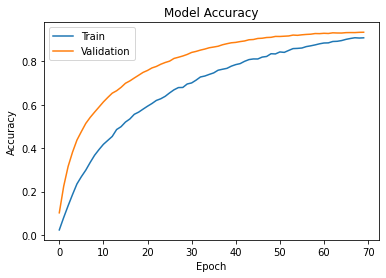

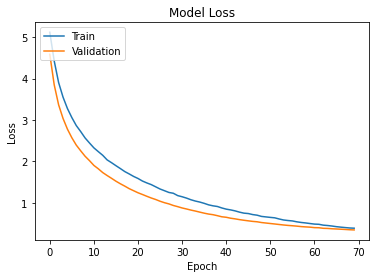

Evaluation Metrics:
F1 Score: 0.9402
Recall: 0.9297
Precision: 0.9522
Accuracy: 0.9297

Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.83      0.78      0.81        37
           2       0.94      0.98      0.96        47
           3       0.96      0.90      0.93        49
           4       1.00      0.88      0.94        43
           5       0.96      0.96      0.96        50
           6       0.93      0.98      0.95        41
           7       0.91      0.89      0.90        54
           8       0.86      0.98      0.92        45
           9       0.92      0.90      0.91        39
          10       0.98      0.96      0.97        47
          11       0.98      0.89      0.93        46
          12       0.86      0.93      0.89        45
          13       0.92      0.86      0.89        51
          14       0.94      0.87      0.90        52
          15       0.98 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
%%script echo skipped
plot_experiment_results_knn(history, knn_model_experiment2, test_dataset_preprocessed, test_embeddings2, test_label_embeddings2)

##Experiment3
*   Description: The third experiment uses a custom convolutional neural network with additional layers for image retrieval.
*   Hyper parameters: Adam optimizer, learning rate = default, categorical cross-entropy loss, 20 epochs
*   Architecture: A sequential model with four convolutional layers, four max pooling layers, a flatten layer, two dense layers.
*   Why we chose this model: This experiment uses a custom CNN architecture to compare with pre-trained models. It has fewer parameters than the pre-trained models, which can make it faster to train.

###Define the custom model architecture

In [ ]:
%%script echo skipped
model_experiment3 = tf.keras.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(256, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
])

###Compile the model

In [ ]:
%%script echo skipped
model_experiment3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

###Train the model

In [ ]:
%%script echo skipped
history = model_experiment3.fit(train_dataset_preprocessed, epochs=20, validation_data=valid_dataset_preprocessed)

Epoch 1/20
431/431 [==============================] - 76s 172ms/step - loss: 5.2199 - accuracy: 0.0091 - val_loss: 5.1153 - val_accuracy: 0.0165
Epoch 2/20
431/431 [==============================] - 86s 200ms/step - loss: 5.0618 - accuracy: 0.0187 - val_loss: 4.9099 - val_accuracy: 0.0378
Epoch 3/20
431/431 [==============================] - 69s 160ms/step - loss: 4.7316 - accuracy: 0.0547 - val_loss: 4.5068 - val_accuracy: 0.0979
Epoch 4/20
431/431 [==============================] - 70s 162ms/step - loss: 3.9839 - accuracy: 0.1657 - val_loss: 4.2084 - val_accuracy: 0.1622
Epoch 5/20
431/431 [==============================] - 70s 161ms/step - loss: 2.8945 - accuracy: 0.3699 - val_loss: 4.5738 - val_accuracy: 0.1702
Epoch 6/20
431/431 [==============================] - 70s 161ms/step - loss: 2.1818 - accuracy: 0.5171 - val_loss: 4.8972 - val_accuracy: 0.2075
Epoch 7/20
431/431 [==============================] - 70s 162ms/step - loss: 1.5657 - accuracy: 0.6503 - val_loss: 8.3415 - val_ac

###Extract embeddings from the model

In [ ]:
%%script echo skipped
train_embeddings3, train_label_embeddings3 = extract_embeddings(model_experiment3, train_dataset_preprocessed)
test_embeddings3, test_label_embeddings3 = extract_embeddings(model_experiment3, test_dataset_preprocessed)

###Train the KNN model

In [ ]:
%%script echo skipped
knn_model_experiment3 = train_knn_model(train_embeddings3, train_label_embeddings3)

###Evaluate the model on the test set

In [ ]:
%%script echo skipped
test_loss, test_accuracy = model_experiment3.evaluate(test_dataset_preprocessed)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

293/293 [==============================] - 27s 93ms/step - loss: 9.1340 - accuracy: 0.3682
Test loss: 9.133950233459473
Test accuracy: 0.3682352900505066


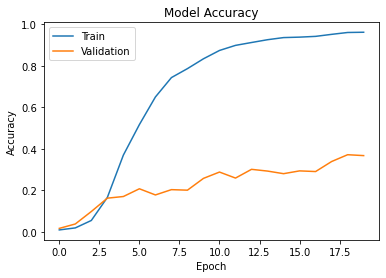

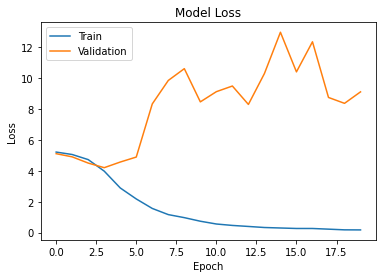

Evaluation Metrics:
F1 Score: 0.3906
Recall: 0.2729
Precision: 0.7342
Accuracy: 0.2729

Classification Report

              precision    recall  f1-score   support

           0       0.91      0.20      0.33        50
           1       0.77      0.27      0.40        37
           2       0.69      0.19      0.30        47
           3       0.67      0.16      0.26        49
           4       0.71      0.23      0.35        43
           5       0.81      0.34      0.48        50
           6       0.69      0.27      0.39        41
           7       0.65      0.20      0.31        54
           8       0.57      0.29      0.38        45
           9       0.86      0.49      0.62        39
          10       0.80      0.26      0.39        47
          11       0.94      0.33      0.48        46
          12       0.73      0.24      0.37        45
          13       0.88      0.27      0.42        51
          14       0.88      0.29      0.43        52
          15       0.94 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
%%script echo skipped
plot_experiment_results_knn(history, knn_model_experiment3, test_dataset_preprocessed, test_embeddings3, test_label_embeddings3)

##Compare the 3 experiments

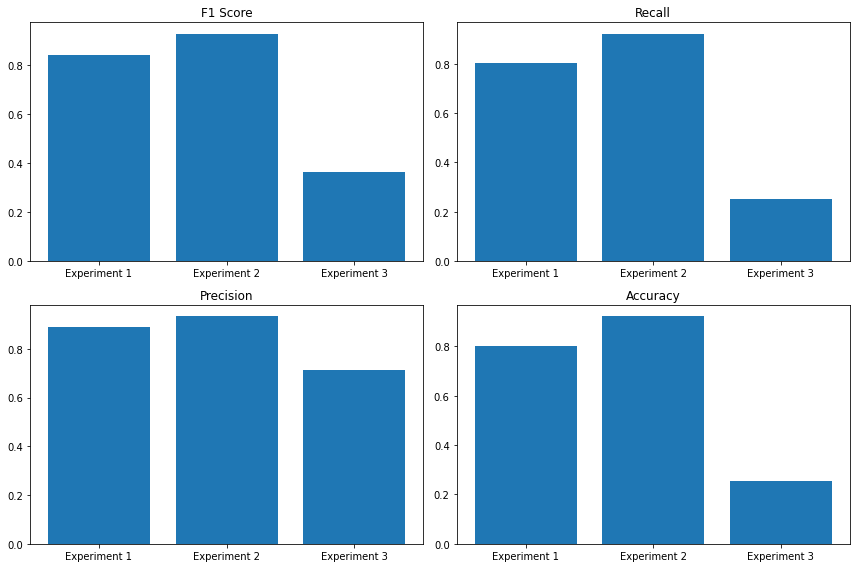

In [ ]:
%%script echo skipped
compare_experiments_image_retrieval(knn_model_experiment1, test_embeddings1, test_label_embeddings1, knn_model_experiment2, test_embeddings2, test_label_embeddings2, knn_model_experiment3, test_embeddings3, test_label_embeddings3)

##Save the best model

In [ ]:
%%script echo skipped
drive.mount('/content/drive')
model_experiment2.save('/content/drive/MyDrive/Colab Notebooks/best_model_image_retrieval.h5')
joblib.dump(knn_model_experiment2, '/content/drive/MyDrive/Colab Notebooks/best_model_image_retrieval_knn.pkl')
np.save('/content/drive/MyDrive/Colab Notebooks/embeddings.npy', train_embeddings2)
np.save('/content/drive/MyDrive/Colab Notebooks/labels.npy', train_label_embeddings2)



Mounted at /content/drive


##General functions for the next 2 configurations

In [ ]:
%%script echo skipped
def plot_experiment_results(model, model_history, test_data):
    # plot training & validation accuracy values
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # plot training & validation loss values
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    test_labels = np.concatenate([y for x, y in test_data], axis=0)
    test_labels=np.argmax(test_labels, axis=1)
    test_predictions = model.predict(test_data)
    test_predictions = np.argmax(test_predictions, axis=1)

    # compute and print different evaluation metrics
    f1_score = metrics.f1_score(test_labels, test_predictions, average='weighted')
    recall = metrics.recall_score(test_labels, test_predictions, average='weighted')
    precision = metrics.precision_score(test_labels, test_predictions, average='weighted')
    accuracy = metrics.accuracy_score(test_labels, test_predictions)
    print('Evaluation Metrics:')
    print(f'F1 Score: {f1_score:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Accuracy: {accuracy:.4f}')

    
    print('\nClassification Report\n')
    print(classification_report(test_labels, test_predictions))

In [ ]:
%%script echo skipped
def compare_experiments(models, test_datasets):
    # create empty lists to store results
    model_names = []
    test_accuracy = []
    test_precision = []
    test_recall = []
    test_f1_score = []
    test_loss = []
    confusion_matrices = []

    # evaluate each model on its corresponding test set
    for i, model in enumerate(models):
        test_dataset = test_datasets[i]
        test_loss_, test_accuracy_, test_precision_, test_recall_ = model.evaluate(test_dataset, verbose=0)
        test_f1_score_ = 2 * (test_precision_ * test_recall_) / (test_precision_ + test_recall_)
        test_predictions = model.predict(test_dataset)
        test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
        test_labels = np.argmax(test_labels, axis=1)
        test_predictions = np.argmax(test_predictions, axis=1)
        confusion_matrix = pd.crosstab(test_labels, test_predictions, rownames=['True'], colnames=['Predicted'], margins=True)

        # add results to the corresponding lists
        model_names.append(f'Model {i+1}')
        test_loss.append(test_loss_)
        test_accuracy.append(test_accuracy_)
        test_precision.append(test_precision_)
        test_recall.append(test_recall_)
        test_f1_score.append(test_f1_score_)
        confusion_matrices.append(confusion_matrix)

    # plot test accuracy, precision, recall, f1-score and loss
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'loss']
    for i, metric in enumerate(metrics):
        ax = axes[i//3, i%3]
        ax.set_title(metric.capitalize())
        ax.bar(model_names, eval(f'test_{metric}'))
        ax.set_ylim([0, 1])

    # plot confusion matrices
    #fig, axes = plt.subplots(1, len(models), figsize=(20, 10))
    #for i, confusion_matrix in enumerate(confusion_matrices):
    #    ax = axes[i]
    #    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', ax=ax)
    #    ax.set_title(f'Model {i+1}')

    # print results as a table
    results_df = pd.DataFrame({'Model': model_names,
                               'Accuracy': test_accuracy,
                               'Precision': test_precision,
                               'Recall': test_recall,
                               'F1-Score': test_f1_score,
                               'Loss': test_loss})
    display(results_df)    


#Transfer Learning Configuration

##Experiment1
*   Description of the experiment: Transfer learning using MobileNetV2 pre-trained model with a new dense layer on top.
*   Hyperparameters: learning rate = 1e-4, batch size = 32, epochs = 70.
*   Architecture: MobileNetV2 pre-trained model with a new dense layer on top, which was trained to predict the category of the images.
*   Why we chose this model: MobileNetV2 is a popular pre-trained model for image classification tasks. We chose it because it has a good balance between accuracy and speed, and it is suitable for mobile and embedded applications.


###Define the image preprocessing function for MobileNetV2

In [ ]:
%%script echo skipped
def preprocess_image_mobilenet(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    label = tf.one_hot(label, depth=num_classes) 
    return image, label

###Prepare the datasets for training and validation

In [ ]:
%%script echo skipped
train_dataset_mobilenet = train_data.map(preprocess_image_mobilenet).batch(32).prefetch(1)
valid_dataset_mobilenet = valid_data.map(preprocess_image_mobilenet).batch(32).prefetch(1)

###Load the pre-trained MobileNetV2 model and add a new dense layer on top

In [ ]:
%%script echo skipped
base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(196, activation='softmax')(x)
model_experiment1 = tf.keras.Model(inputs=base_model.input, outputs=x)

9406464/9406464 [==============================] - 0s 0us/step


###Compile the model

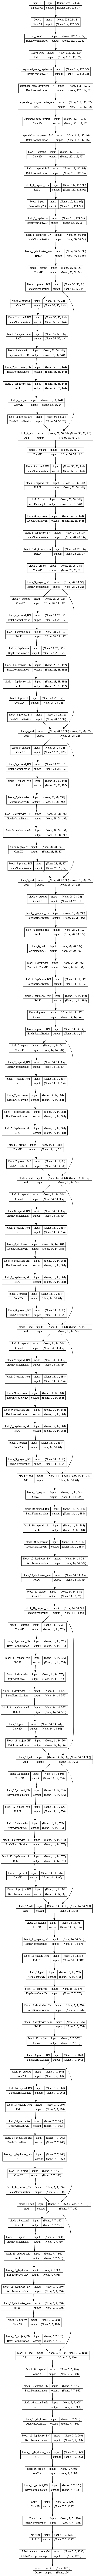

In [ ]:
%%script echo skipped
model_experiment1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                          loss='categorical_crossentropy',
                          metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

tf.keras.utils.plot_model(model_experiment1, to_file='TL_model_experiment1.png', show_shapes=True, show_layer_names=True)

###Train the model

In [ ]:
%%script echo skipped
history_experiment1 = model_experiment1.fit(train_dataset_mobilenet, epochs=70, validation_data=valid_dataset_mobilenet)

Epoch 1/70
431/431 [==============================] - 62s 116ms/step - loss: 4.9943 - accuracy: 0.0333 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 4.5250 - val_accuracy: 0.0836 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/70
431/431 [==============================] - 48s 111ms/step - loss: 4.2696 - accuracy: 0.1295 - precision: 1.0000 - recall: 7.2606e-05 - val_loss: 3.9894 - val_accuracy: 0.1898 - val_precision: 1.0000 - val_recall: 3.2086e-04
Epoch 3/70
431/431 [==============================] - 48s 112ms/step - loss: 3.8115 - accuracy: 0.2272 - precision: 1.0000 - recall: 0.0015 - val_loss: 3.6084 - val_accuracy: 0.2819 - val_precision: 1.0000 - val_recall: 0.0027
Epoch 4/70
431/431 [==============================] - 48s 112ms/step - loss: 3.4705 - accuracy: 0.3053 - precision: 1.0000 - recall: 0.0047 - val_loss: 3.3156 - val_accuracy: 0.3540 - val_precision: 1.0000 - val_recall: 0.0070
Epoch 5/70
431/431 [==============================] - 45s 105ms/step

###Evaluate the model

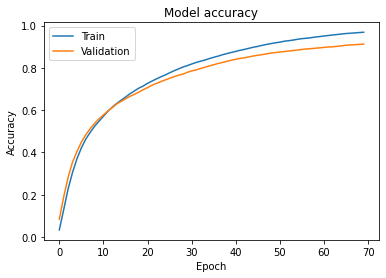

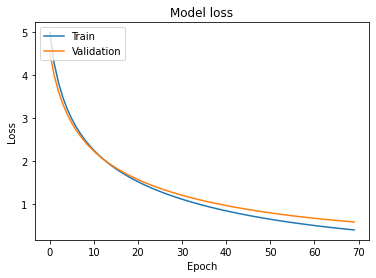

293/293 [==============================] - 19s 62ms/step
Evaluation Metrics:
F1 Score: 0.1039
Recall: 0.1040
Precision: 0.1041
Accuracy: 0.1040

Classification Report

              precision    recall  f1-score   support

           0       0.08      0.08      0.08        50
           1       0.03      0.03      0.03        37
           2       0.06      0.06      0.06        47
           3       0.14      0.14      0.14        49
           4       0.16      0.16      0.16        43
           5       0.13      0.12      0.12        50
           6       0.08      0.10      0.09        41
           7       0.12      0.13      0.12        54
           8       0.13      0.13      0.13        45
           9       0.11      0.10      0.11        39
          10       0.09      0.09      0.09        47
          11       0.09      0.09      0.09        46
          12       0.07      0.09      0.08        45
          13       0.02      0.02      0.02        51
          14       0.

In [ ]:
%%script echo skipped
test_dataset_mobilenet = test_data.map(preprocess_image_mobilenet).batch(32).prefetch(1)
plot_experiment_results(model_experiment1, history_experiment1, test_dataset_mobilenet)


##Experiment2
*  Description of the experiment: This experiment uses the InceptionV3 pre-trained model with two new dense layers on top, which were trained to predict the category of the images. The weights of the pre-trained layers were frozen, and only the newly added layers were trained.
*  Hyperparameters: Learning rate = 1e-3, batch size = 32, epochs = 15.
*  Architecture: InceptionV3 pre-trained model with two new dense layers on top.
*  Why we chose this model: InceptionV3 is a powerful pre-trained model for image classification tasks. It has shown good performance on various datasets. The added dense layers can help improve the model's performance by learning task-specific features.

###Define the image preprocessing function for InceptionV3

In [ ]:
%%script echo skipped
def preprocess_image_inception(image, label):
    image = tf.image.resize(image, (299, 299))
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    label = tf.one_hot(label, depth=num_classes) 
    return image, label


###Prepare the datasets for training and validation

In [ ]:
%%script echo skipped
train_dataset_inception = train_data.map(preprocess_image_inception).batch(32).prefetch(1)
valid_dataset_inception = valid_data.map(preprocess_image_inception).batch(32).prefetch(1)

###Load the pre-trained InceptionV3 model and add two new dense layers on top

In [ ]:
%%script echo skipped
base_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(196, activation='softmax')(x)
model_experiment2 = tf.keras.Model(inputs=base_model.input, outputs=x)

87910968/87910968 [==============================] - 0s 0us/step


###Compile the model

In [ ]:
%%script echo skipped
model_experiment2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                          loss='categorical_crossentropy',
                          metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

tf.keras.utils.plot_model(model_experiment2, to_file='TL_model_experiment2.png', show_shapes=True, show_layer_names=True)

###Train the model

In [ ]:
%%script echo skipped
history_experiment2 = model_experiment2.fit(train_dataset_inception, epochs=15, validation_data=valid_dataset_inception)

Epoch 1/15
431/431 [==============================] - 96s 207ms/step - loss: 3.2539 - accuracy: 0.2350 - precision_1: 0.6942 - recall_1: 0.0458 - val_loss: 2.3708 - val_accuracy: 0.3864 - val_precision_1: 0.7255 - val_recall_1: 0.1614
Epoch 2/15
431/431 [==============================] - 85s 198ms/step - loss: 1.9184 - accuracy: 0.5092 - precision_1: 0.8494 - recall_1: 0.2233 - val_loss: 1.7562 - val_accuracy: 0.5215 - val_precision_1: 0.7437 - val_recall_1: 0.3361
Epoch 3/15
431/431 [==============================] - 85s 197ms/step - loss: 1.3138 - accuracy: 0.6591 - precision_1: 0.8952 - recall_1: 0.4147 - val_loss: 1.6235 - val_accuracy: 0.5528 - val_precision_1: 0.7362 - val_recall_1: 0.4120
Epoch 4/15
431/431 [==============================] - 85s 197ms/step - loss: 0.9573 - accuracy: 0.7618 - precision_1: 0.9244 - recall_1: 0.5567 - val_loss: 1.2300 - val_accuracy: 0.6601 - val_precision_1: 0.8120 - val_recall_1: 0.5349
Epoch 5/15
431/431 [==============================] - 85s 19

###Evaluate the model

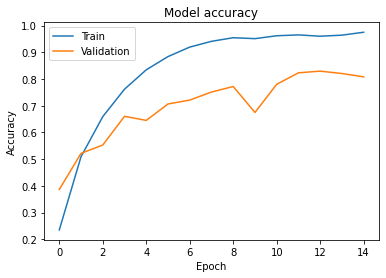

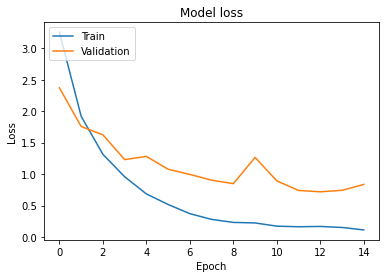

293/293 [==============================] - 35s 115ms/step
Evaluation Metrics:
F1 Score: 0.0051
Recall: 0.0052
Precision: 0.0054
Accuracy: 0.0052

Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        37
           2       0.00      0.00      0.00        47
           3       0.00      0.00      0.00        49
           4       0.00      0.00      0.00        43
           5       0.02      0.02      0.02        50
           6       0.00      0.00      0.00        41
           7       0.02      0.02      0.02        54
           8       0.01      0.07      0.02        45
           9       0.00      0.00      0.00        39
          10       0.00      0.00      0.00        47
          11       0.00      0.00      0.00        46
          12       0.00      0.00      0.00        45
          13       0.00      0.00      0.00        51
          14       0

In [ ]:
%%script echo skipped
test_dataset_inception = test_data.map(preprocess_image_inception).batch(32).prefetch(1)
plot_experiment_results(model_experiment2, history_experiment2, test_dataset_inception)

##Experiment3
*  Description of the experiment: Transfer Learning using ResNet50V2 pre-trained model with a new dense layer on top.
*  Hyperparameters: learning rate = 1e-4, batch size = 32, epochs = 60.
*  Augmentation: Random left-right flipping was applied to the images.
*  Architecture: ResNet50V2 pre-trained model with a new dense layer on top, which was trained to predict the category of the images.
*  Why we chose this model: ResNet50V2 is a state-of-the-art pre-trained model for image classification tasks. We chose it because it has a high accuracy and is suitable for complex image recognition tasks.

###Define the image preprocessing function for ResNet50V2

In [ ]:
%%script echo skipped
def preprocess_image_resnet(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.resnet_v2.preprocess_input(image)
    label = tf.one_hot(label, depth=num_classes) 
    return image, label

###Prepare the datasets for training and validation

In [ ]:
%%script echo skipped
train_dataset_resnet = train_data.map(preprocess_image_resnet).map(lambda x, y: (tf.image.random_flip_left_right(x), y)).batch(32).prefetch(1)
valid_dataset_resnet = valid_data.map(preprocess_image_resnet).batch(32).prefetch(1)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


###Load the pre-trained ResNet50V2 model and add a new dense layer on top

In [ ]:
%%script echo skipped
base_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(196, activation='softmax')(x)
model_experiment3 = tf.keras.Model(inputs=base_model.input, outputs=x)

94668760/94668760 [==============================] - 0s 0us/step


###Compile the model

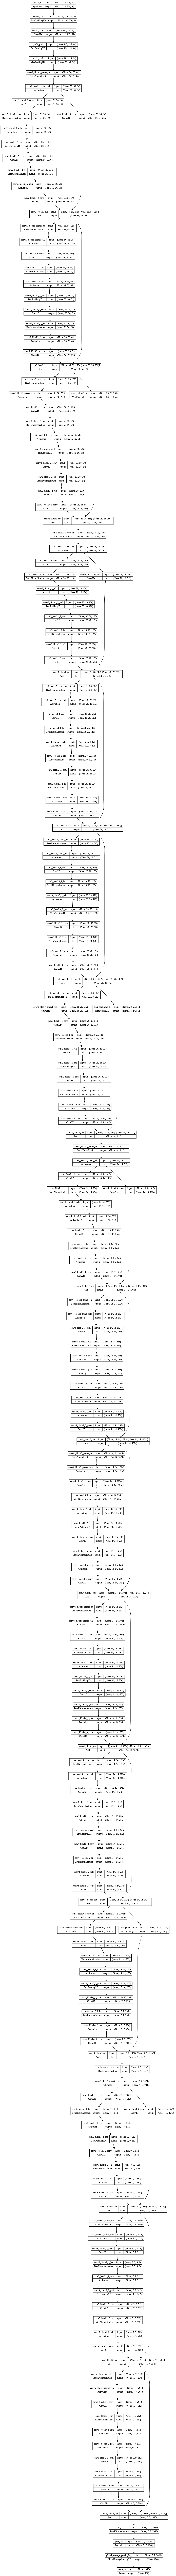

In [ ]:
%%script echo skipped
model_experiment3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                          loss='categorical_crossentropy',
                          metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

tf.keras.utils.plot_model(model_experiment3, to_file='TL_model_experiment3.png', show_shapes=True, show_layer_names=True)

###Train the model

In [ ]:
%%script echo skipped
history_experiment3 = model_experiment3.fit(train_dataset_resnet, epochs=60, validation_data=valid_dataset_resnet)

Epoch 1/60
431/431 [==============================] - 68s 148ms/step - loss: 4.9981 - accuracy: 0.0363 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 4.3937 - val_accuracy: 0.0995 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/60
431/431 [==============================] - 61s 142ms/step - loss: 4.0914 - accuracy: 0.1452 - precision_2: 1.0000 - recall_2: 2.9042e-04 - val_loss: 3.7766 - val_accuracy: 0.2187 - val_precision_2: 0.9286 - val_recall_2: 0.0028
Epoch 3/60
431/431 [==============================] - 61s 142ms/step - loss: 3.5823 - accuracy: 0.2507 - precision_2: 0.9222 - recall_2: 0.0060 - val_loss: 3.3712 - val_accuracy: 0.3086 - val_precision_2: 0.9490 - val_recall_2: 0.0099
Epoch 4/60
431/431 [==============================] - 78s 181ms/step - loss: 3.2273 - accuracy: 0.3283 - precision_2: 0.9484 - recall_2: 0.0147 - val_loss: 3.0735 - val_accuracy: 0.3720 - val_precision_2: 0.9289 - val_recall_2: 0.0196
Epoch 5/60
431/431 [====================

###Evaluate the model

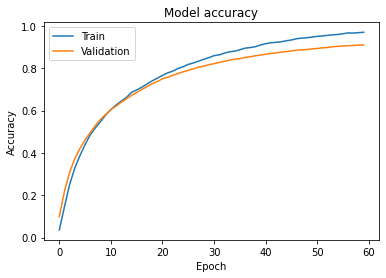

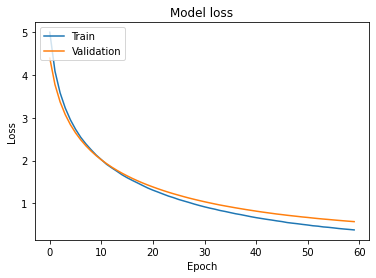

293/293 [==============================] - 25s 81ms/step
Evaluation Metrics:
F1 Score: 0.0066
Recall: 0.0065
Precision: 0.0066
Accuracy: 0.0065

Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        37
           2       0.00      0.00      0.00        47
           3       0.00      0.00      0.00        49
           4       0.00      0.00      0.00        43
           5       0.06      0.06      0.06        50
           6       0.02      0.02      0.02        41
           7       0.02      0.02      0.02        54
           8       0.00      0.00      0.00        45
           9       0.00      0.00      0.00        39
          10       0.02      0.02      0.02        47
          11       0.00      0.00      0.00        46
          12       0.00      0.00      0.00        45
          13       0.00      0.00      0.00        51
          14       0.

In [ ]:
%%script echo skipped
test_dataset_resnet = test_data.map(preprocess_image_resnet).batch(32).prefetch(1)
plot_experiment_results(model_experiment3, history_experiment3, test_dataset_resnet)

##Compare the 3 experiments

293/293 [==============================] - 24s 83ms/step


Model  Accuracy  Precision    Recall  F1-Score      Loss
0  Model 1  0.916364   0.982525  0.775722  0.866961  0.569849
1  Model 2  0.810481   0.851150  0.783422  0.815883  0.792038
2  Model 3  0.912406   0.978607  0.787701  0.872837  0.559037

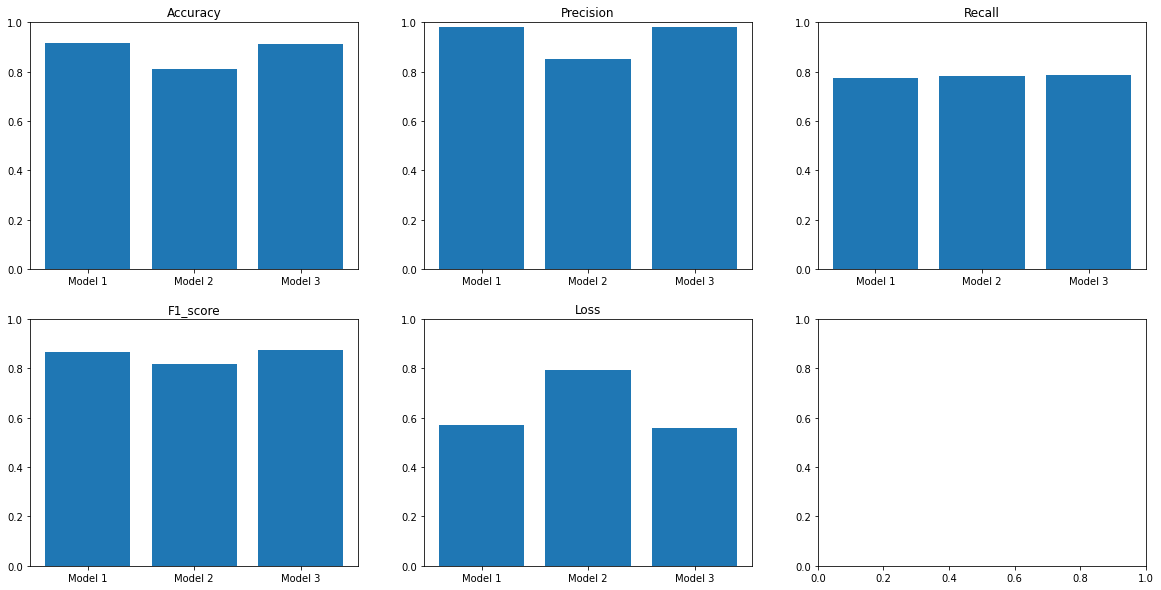

In [ ]:
%%script echo skipped
models = [model_experiment1, model_experiment2, model_experiment3]
test_datasets = [test_dataset_mobilenet, test_dataset_inception, test_dataset_resnet]
compare_experiments(models, test_datasets)

##Save the best model

In [ ]:
%%script echo skipped
drive.mount('/content/drive')
model_experiment3.save('/content/drive/MyDrive/Colab Notebooks/best_model_transfer_learning.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#CNN End to END Configuration

##Experiment1
*  Description: The experiment uses a custom CNN architecture with four convolutional layers and two dense layers for image classification.
*  Hyperparameters: Adam optimizer, learning rate = 1e-4, batch size = 32, and 25 epochs.
*  Augmentation: Random left-right flipping and rotation are applied to the images during preprocessing.
*  Architecture: The model consists of four convolutional layers, followed by max-pooling layers. It also has two dense layers, with the last one having 196 units to output the class probabilities.
*  Why we chose this model: This experiment uses a custom CNN architecture to compare with pre-trained models. The model has fewer parameters than the pre-trained models, which can make it faster to train. The model also includes data augmentation, which can help prevent overfitting.

###Define the image preprocessing function for the custom CNN

In [ ]:
%%script echo skipped
def preprocess_image_custom(image, label):
    image = tf.image.resize(image, (224, 224)) 
    image = tf.image.random_flip_left_right(image)
    image = tf.image.rot90(image, k=np.random.randint(4))
    image = tf.cast(image, tf.float32) / 255.
    label = tf.one_hot(label, depth=num_classes) 
    return image, label

###Prepare the datasets for training and validation

In [ ]:
%%script echo skipped
train_dataset_custom = train_data.map(preprocess_image_custom).batch(32).prefetch(1)
valid_dataset_custom = valid_data.map(preprocess_image_custom).batch(32).prefetch(1)

###Define the custom CNN architecture

In [ ]:
%%script echo skipped
model_experiment1 = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(196, activation='softmax')
])

###Compile the model

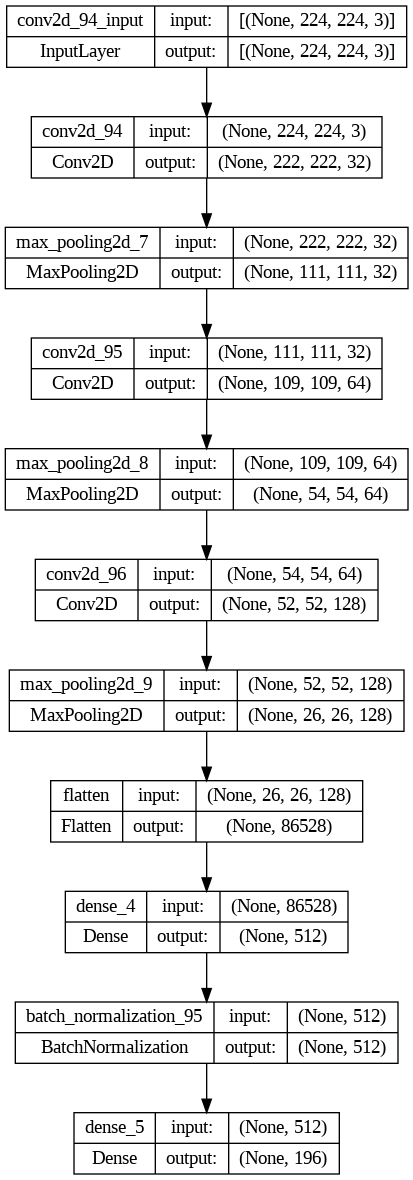

In [ ]:
%%script echo skipped
model_experiment1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                          loss='categorical_crossentropy',
                          metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

tf.keras.utils.plot_model(model_experiment1, to_file='CNN_model_experiment1.png', show_shapes=True, show_layer_names=True)

###Train the model

In [ ]:
%%script echo skipped
history_experiment1 = model_experiment1.fit(train_dataset_custom, epochs=25, validation_data=valid_dataset_custom)

Epoch 1/25
431/431 [==============================] - 53s 113ms/step - loss: 5.1151 - accuracy: 0.0295 - precision_3: 0.2857 - recall_3: 1.4521e-04 - val_loss: 5.2136 - val_accuracy: 0.0224 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/25
431/431 [==============================] - 48s 112ms/step - loss: 4.1716 - accuracy: 0.2078 - precision_3: 0.8621 - recall_3: 0.0073 - val_loss: 5.7077 - val_accuracy: 0.0164 - val_precision_3: 0.2200 - val_recall_3: 0.0012
Epoch 3/25
431/431 [==============================] - 50s 116ms/step - loss: 2.8717 - accuracy: 0.5583 - precision_3: 0.9951 - recall_3: 0.1022 - val_loss: 6.2518 - val_accuracy: 0.0141 - val_precision_3: 0.0497 - val_recall_3: 9.6257e-04
Epoch 4/25
431/431 [==============================] - 47s 109ms/step - loss: 1.8932 - accuracy: 0.7541 - precision_3: 0.9981 - recall_3: 0.3129 - val_loss: 6.1365 - val_accuracy: 0.0144 - val_precision_3: 0.0789 - val_recall_3: 6.4171e-04
Epoch 5/25
431/431 [====================

###Evaluate the model

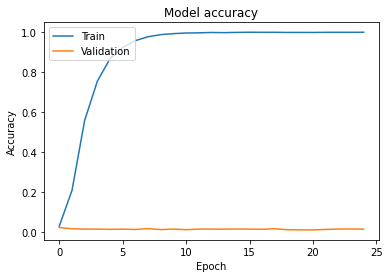

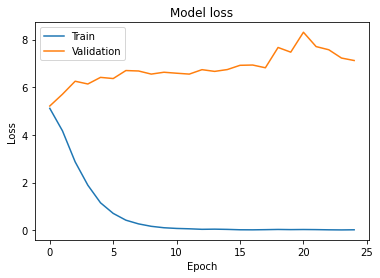

293/293 [==============================] - 18s 61ms/step
Evaluation Metrics:
F1 Score: 0.0026
Recall: 0.0041
Precision: 0.0100
Accuracy: 0.0041

Classification Report

              precision    recall  f1-score   support

           0       0.00      0.02      0.01        50
           1       0.00      0.00      0.00        37
           2       0.00      0.00      0.00        47
           3       0.00      0.00      0.00        49
           4       0.00      0.00      0.00        43
           5       0.00      0.00      0.00        50
           6       0.00      0.00      0.00        41
           7       0.00      0.00      0.00        54
           8       0.00      0.00      0.00        45
           9       0.00      0.00      0.00        39
          10       0.00      0.00      0.00        47
          11       0.00      0.00      0.00        46
          12       0.00      0.00      0.00        45
          13       0.00      0.00      0.00        51
          14       0.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: 

In [ ]:
%%script echo skipped
test_dataset_custom = test_data.map(preprocess_image_custom).batch(32).prefetch(1)
plot_experiment_results(model_experiment1, history_experiment1, test_dataset_custom)

##Experiment2
*  Description: Custom CNN with various image augmentations.
*  Hyperparameters: learning rate = 1e-4, batch size = 32, epochs = 20.
*  Augmentation: Image augmentation techniques used in the preprocessing function include resizing, random cropping, left-right flipping, rotation, and brightness adjustment.
*  Architecture: Custom CNN architecture with multiple convolutional and max pooling layers, followed by two dense layers for classification.
*  Why we chose this model: We chose this model because it allows us to experiment with various image augmentations, which can improve model performance and make the model more robust to variations in the input images.

###Define the image preprocessing function for the custom CNN

In [ ]:
%%script echo skipped
def preprocess_image_custom(image, label):
    image = tf.image.resize_with_pad(image, 224, 224)
    image = tf.image.random_crop(image, size=[224, 224, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.rot90(image, k=np.random.randint(4))
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.cast(image, tf.float32) / 255.
    label = tf.one_hot(label, depth=num_classes) 
    return image, label

###Prepare the datasets for training and validation

In [ ]:
%%script echo skipped
train_dataset_custom = train_data.map(preprocess_image_custom).batch(32).prefetch(1)
valid_dataset_custom = valid_data.map(preprocess_image_custom).batch(32).prefetch(1)

###Define the custom CNN architecture

In [ ]:
%%script echo skipped
model_experiment2 = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(196, activation='softmax')
])

###Define the learning rate schedule

In [ ]:
%%script echo skipped
def lr_schedule(epoch, lr):
    if epoch < 50:
        return lr
    elif epoch < 75:
        return lr / 10.
    else:
        return lr / 100.

###Compile the model

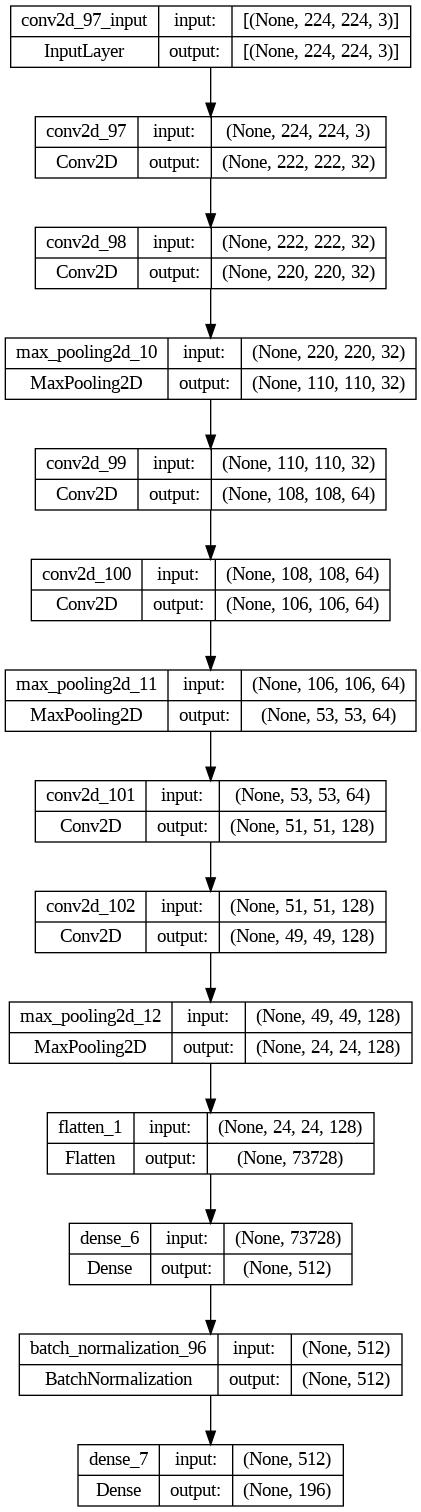

In [ ]:
%%script echo skipped
model_experiment2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                          loss='categorical_crossentropy',
                          metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

tf.keras.utils.plot_model(model_experiment2, to_file='CNN_model_experiment2.png', show_shapes=True, show_layer_names=True)

###Train the model

In [ ]:
%%script echo skipped
history_experiment2 = model_experiment2.fit(train_dataset_custom, epochs=20, validation_data=valid_dataset_custom,
                                            callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

Epoch 1/20
431/431 [==============================] - 77s 168ms/step - loss: 5.0649 - accuracy: 0.0266 - precision_4: 0.5000 - recall_4: 1.4521e-04 - val_loss: 5.2585 - val_accuracy: 0.0090 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/20
431/431 [==============================] - 71s 165ms/step - loss: 4.5390 - accuracy: 0.0949 - precision_4: 0.5714 - recall_4: 0.0015 - val_loss: 6.1065 - val_accuracy: 0.0102 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/20
431/431 [==============================] - 71s 164ms/step - loss: 3.8002 - accuracy: 0.2721 - precision_4: 0.9265 - recall_4: 0.0091 - val_loss: 7.5658 - val_accuracy: 0.0099 - val_precision_4: 0.0102 - val_recall_4: 0.0011 - lr: 1.0000e-04
Epoch 4/20
431/431 [==============================] - 71s 165ms/step - loss: 2.8711 - accuracy: 0.5346 - precision_4: 0.9950 - recall_4: 0.0576 - val_loss: 8.9909 - val_accuracy: 0.0083 - val_precision_4: 0.0106 - val_recall

###Evaluate the model

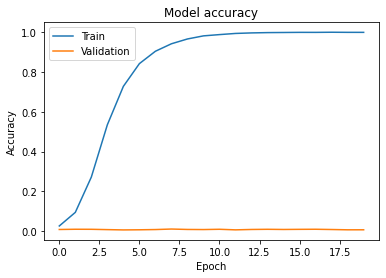

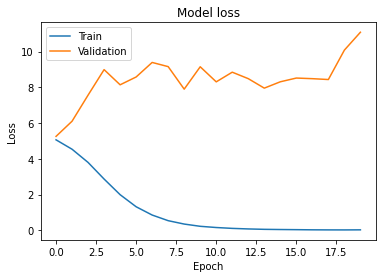

293/293 [==============================] - 19s 63ms/step
Evaluation Metrics:
F1 Score: 0.0016
Recall: 0.0061
Precision: 0.0042
Accuracy: 0.0061

Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        37
           2       0.00      0.00      0.00        47
           3       0.00      0.00      0.00        49
           4       0.00      0.00      0.00        43
           5       0.00      0.00      0.00        50
           6       0.00      0.00      0.00        41
           7       0.00      0.00      0.00        54
           8       0.00      0.00      0.00        45
           9       0.00      0.00      0.00        39
          10       0.00      0.00      0.00        47
          11       0.00      0.00      0.00        46
          12       0.00      0.00      0.00        45
          13       0.00      0.00      0.00        51
          14       0.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: 

In [ ]:
%%script echo skipped
test_dataset_custom = test_data.map(preprocess_image_custom).batch(32).prefetch(1)
plot_experiment_results(model_experiment2, history_experiment2, test_dataset_custom)

##Experiment3
*  Description: This experiment is about training a custom CNN to classify images using a combination of various image preprocessing techniques and deep learning techniques. The model architecture consists of convolutional, batch normalization, max-pooling, and dense layers with dropout and data augmentation applied to improve performance.
*  Hyper parameters: learning rate = 1e-4, batch size = 64, epochs = 100, early stopping patience = 30.
*  Augmentation: random cropping, left-right flipping, rotation, brightness and contrast adjustment were applied to the images.
*  Architecture: The model architecture consists of convolutional, batch normalization, max-pooling, and dense layers with dropout. The input image size is 224x224x3, and the model outputs a prediction for one of the 196 classes.
*  Why we chose each model: The custom CNN architecture was chosen to allow for flexibility in designing a model that suits our specific task requirements. The various techniques applied during preprocessing and training were chosen to improve the model's accuracy and performance.

###Define the image preprocessing function for the custom CNN

In [ ]:
%%script echo skipped
def preprocess_image_custom(image, label):
    image = tf.image.resize(image, (256, 256))
    image = tf.image.random_crop(image, size=[224, 224, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.rot90(image, k=np.random.randint(4))
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.cast(image, tf.float32) / 255.
    label = tf.one_hot(label, depth=num_classes) 
    return image, label

###Prepare the datasets for training and validation

In [ ]:
%%script echo skipped
train_dataset_custom = train_data.map(preprocess_image_custom).batch(64).prefetch(1)
valid_dataset_custom = valid_data.map(preprocess_image_custom).batch(64).prefetch(1)

###Define the custom CNN architecture

In [ ]:
%%script echo skipped
model_experiment3 = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(196, activation='softmax')
])

###Define the learning rate schedule

In [ ]:
%%script echo skipped
def lr_schedule(epoch, lr):
  if epoch < 50:
    return lr
  elif epoch < 100:
    return lr / 10.
  elif epoch < 125:
    return lr / 100.
  else:
    return lr / 1000.

###Compile the model

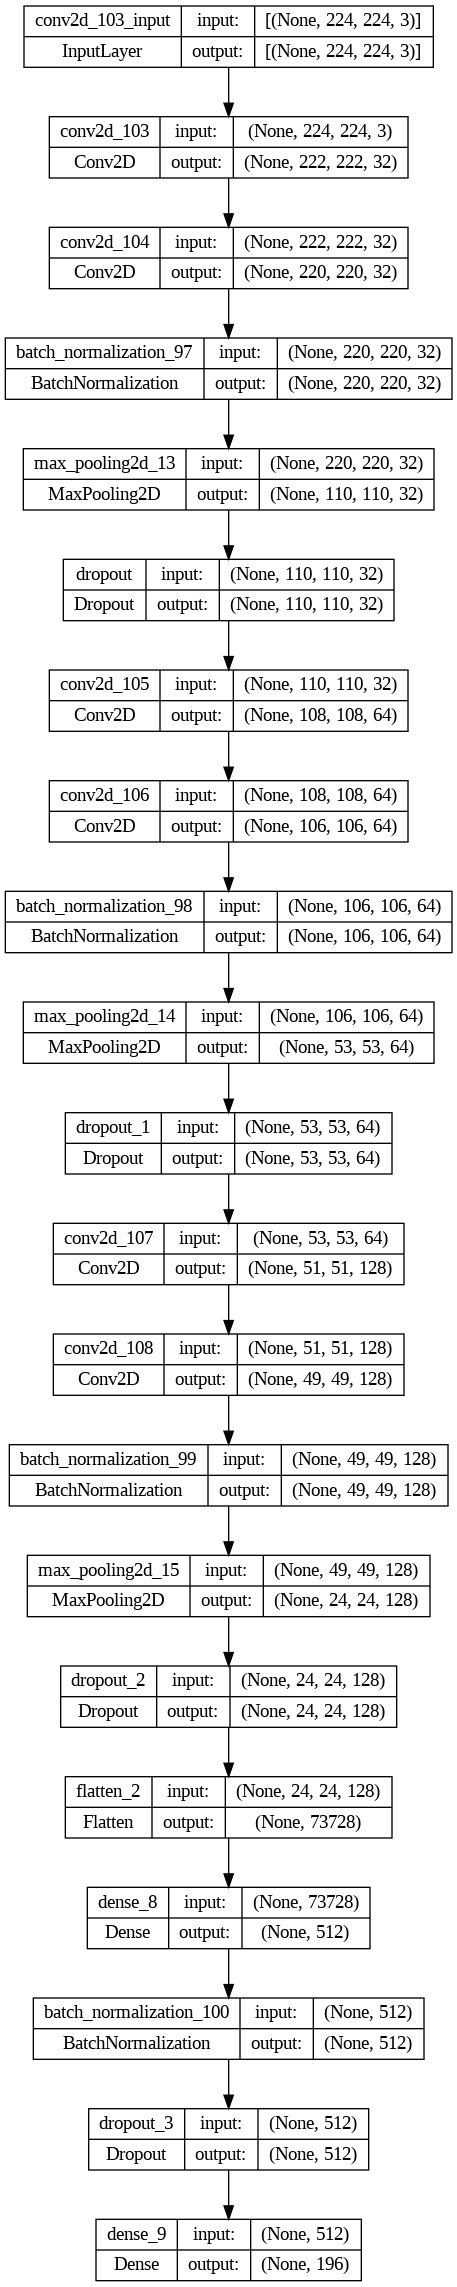

In [ ]:
%%script echo skipped
model_experiment3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                          loss='categorical_crossentropy',
                          metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

tf.keras.utils.plot_model(model_experiment3, to_file='CNN_model_experiment3.png', show_shapes=True, show_layer_names=True)

###Train the model

In [ ]:
%%script echo skipped
history_experiment3 = model_experiment3.fit(train_dataset_custom, epochs=100, validation_data=valid_dataset_custom,
                                            callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule),
                                                       tf.keras.callbacks.EarlyStopping(patience=30),
                                                       tf.keras.callbacks.ModelCheckpoint('best_model_experiment3.h5',save_best_only=True)])

Epoch 1/100
216/216 [==============================] - 117s 507ms/step - loss: 5.8181 - accuracy: 0.0122 - precision_5: 0.0169 - recall_5: 1.4521e-04 - val_loss: 27.1213 - val_accuracy: 0.0053 - val_precision_5: 0.0056 - val_recall_5: 0.0044 - lr: 1.0000e-04
Epoch 2/100
216/216 [==============================] - 108s 500ms/step - loss: 5.3577 - accuracy: 0.0250 - precision_5: 0.0802 - recall_5: 0.0012 - val_loss: 36.9582 - val_accuracy: 0.0051 - val_precision_5: 0.0052 - val_recall_5: 0.0046 - lr: 1.0000e-04
Epoch 3/100
216/216 [==============================] - 111s 513ms/step - loss: 5.1819 - accuracy: 0.0341 - precision_5: 0.1532 - recall_5: 0.0026 - val_loss: 16.0333 - val_accuracy: 0.0078 - val_precision_5: 0.0062 - val_recall_5: 0.0031 - lr: 1.0000e-04
Epoch 4/100
216/216 [==============================] - 109s 505ms/step - loss: 5.0289 - accuracy: 0.0442 - precision_5: 0.2079 - recall_5: 0.0042 - val_loss: 8.9849 - val_accuracy: 0.0220 - val_precision_5: 0.0102 - val_recall_5: 0

###Evaluate the model

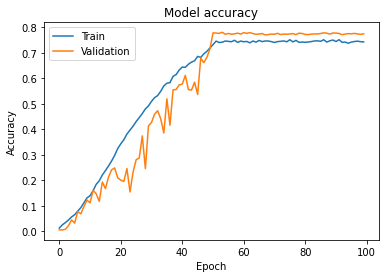

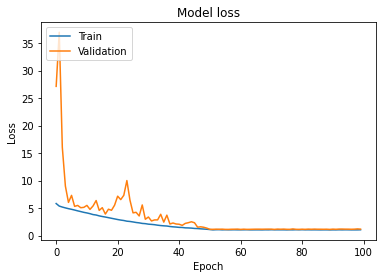

147/147 [==============================] - 21s 143ms/step
Evaluation Metrics:
F1 Score: 0.0035
Recall: 0.0047
Precision: 0.0049
Accuracy: 0.0047

Classification Report

              precision    recall  f1-score   support

           0       0.00      0.02      0.00        50
           1       0.00      0.00      0.00        37
           2       0.00      0.00      0.00        47
           3       0.00      0.00      0.00        49
           4       0.00      0.00      0.00        43
           5       0.00      0.00      0.00        50
           6       0.00      0.00      0.00        41
           7       0.00      0.00      0.00        54
           8       0.00      0.00      0.00        45
           9       0.00      0.00      0.00        39
          10       0.00      0.00      0.00        47
          11       0.00      0.00      0.00        46
          12       0.00      0.00      0.00        45
          13       0.00      0.00      0.00        51
          14       0

In [ ]:
%%script echo skipped
test_dataset_custom = test_data.map(preprocess_image_custom).batch(64).prefetch(1)
plot_experiment_results(model_experiment3, history_experiment3, test_dataset_custom)

##Compare the 3 experiments

147/147 [==============================] - 22s 148ms/step


Model  Accuracy  Precision    Recall  F1-Score      Loss
0  Model 1  0.015294   0.025556  0.002460  0.004488  7.238429
1  Model 2  0.007914   0.006061  0.002353  0.003390  9.035905
2  Model 3  0.045989   0.088156  0.014011  0.024179  6.414746

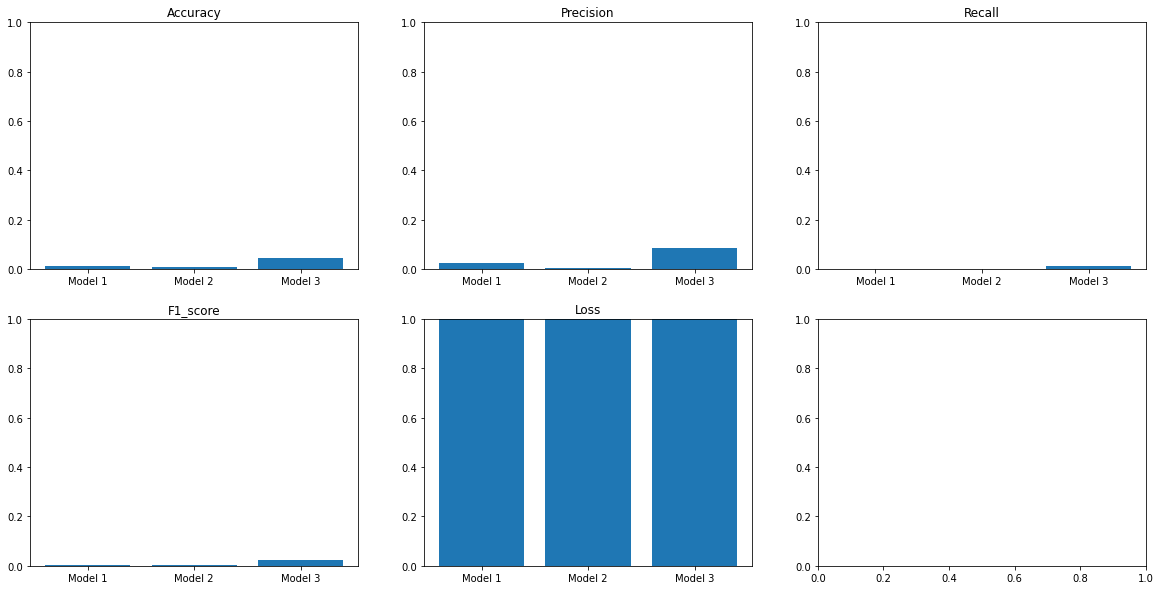

In [ ]:
%%script echo skipped
models = [model_experiment1, model_experiment2, model_experiment3]
test_datasets = [test_dataset_custom, test_dataset_custom, test_dataset_custom]
compare_experiments(models, test_datasets)

##Save the best model

In [ ]:
%%script echo skipped
drive.mount('/content/drive')
model_experiment3.save('/content/drive/MyDrive/Colab Notebooks/best_model_end_to_end.h5')

Mounted at /content/drive


#Test Environment

In [4]:
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1m1QeEG7w179G13bck7jJzu4b-QJWO52s
!unzip /content/my_files.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1m1QeEG7w179G13bck7jJzu4b-QJWO52s
To: /content/my_files.zip
100% 549M/549M [00:01<00:00, 281MB/s]
Archive:  /content/my_files.zip
  inflating: best_model_transfer_learning.h5  
  inflating: labels_dic.csv          
  inflating: best_model_end_to_end.h5  
  inflating: explainer.md            
  inflating: best_model_image_retrieval.h5  
  inflating: embeddings.npy          
  inflating: labels.npy              
  inflating: best_model_image_retrieval_knn.pkl  


In [20]:
%%capture
[train_data] = tfds.load('Cars196', split=['train+test[:70%]'], as_supervised=True)

In [5]:
label_dic = pd.read_csv('/content/labels_dic.csv', header=None, dtype={0: str}).set_index(0).squeeze().to_dict()

##Load the test image

In [6]:
uploaded = files.upload()
filename = next(iter(uploaded))
test_image = tf.keras.utils.load_img(filename)

Saving car1.jpg to car1.jpg


##Image Retrieval Configuration Test Environment:



###Load the saved models

In [7]:
model = tf.keras.models.load_model('/content/best_model_image_retrieval.h5')
knn_model = joblib.load('/content/best_model_image_retrieval_knn.pkl')

###Define the image preprocessing function for the KNN model

In [8]:
def preprocess_image_knn(image):
    image = tf.image.resize(image, (224, 224))  
    image = tf.cast(image, tf.float32) / 255.
    image = np.expand_dims(np.asarray(image, dtype=np.float32), axis=0)
    return image

###Define the function to retrieve the closest images

In [22]:
def retrieve_closest_images_knn(model, test_image, knn_model, labels, k=5):
    # Preprocess the test image
    test_image = preprocess_image_knn(test_image)
    
    # Get the embedding/"signature" of the test image
    test_embedding = model.predict(test_image)
    
    # Use the KNN model to retrieve the closest images
    distances, indices = knn_model.kneighbors(test_embedding, n_neighbors=k)

    # Get the predicted label of the test image
    predicted_label = np.argmax(model.predict(test_image))
    predicted_class = labels[str(predicted_label)]
    print(f"The input image is classified as {predicted_class} (class {predicted_label}) by the embedded model.")
    
    # Plot the closest images
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Closest {k} images to image_test")

    for i, index in enumerate(indices[0]):
        image, label = list(train_data.skip(index).take(1))[0]
        plt.subplot(1, k, i+1)
        plt.imshow(image.numpy())
        plt.title(f"Distance: {distances[0][i]:.2f}\n{labels[str(label.numpy())]}\n Label: {label.numpy()}")
        plt.axis('off')
    plt.show()

    predicted_label = knn_model.predict(test_embedding)
    predicted_label = np.argmax(predicted_label, axis=1)  # retrieve the predicted class
    predicted_class = predicted_label[0]
    print(f'The input image is classified as {label_dic[str(predicted_class)]} (class {predicted_class}) by the knn model.')

###Retrieve the closest images

1/1 [==============================] - 0s 22ms/step
The input image is classified as BMW 3 Series Sedan 2012 (class 28) by the embedded model.


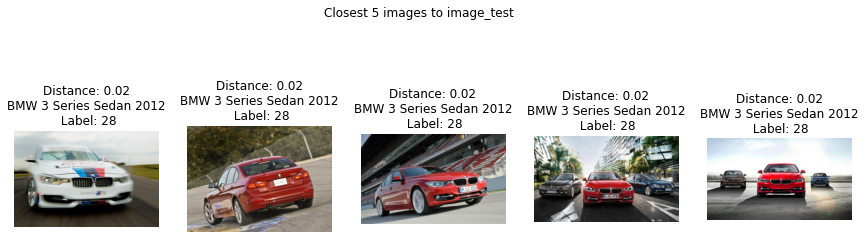

The input image is classified as BMW 3 Series Sedan 2012 (class 28) by the knn model.


In [23]:
retrieve_closest_images_knn(model, test_image, knn_model, label_dic, k=5)

##Transfer Learning Configuration Test Environment:


###Load the saved trained model

In [11]:
model = tf.keras.models.load_model('/content/best_model_transfer_learning.h5')

###Define the image preprocessing function for the transfer learning model

In [12]:
def preprocess_image_transfer_learning(image):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.resnet_v2.preprocess_input(image)
    image = np.expand_dims(image, axis=0)
    return image

###Define the function to predict the class of an input image

In [13]:
def predict_class_transfer_learning(input_image, model):
    # Preprocess the input image
    input_image = preprocess_image_transfer_learning(input_image)
    
    # Make the prediction
    prediction = model.predict(input_image)
    class_id = np.argmax(prediction)
    class_label = label_dic[str(class_id)]
    
    # Print the result
    print(f"The input image is classified as {class_label} (class {class_id}).")

###Predict image class

In [14]:
predict_class_transfer_learning(test_image, model)

1/1 [==============================] - 2s 2s/step
The input image is classified as BMW 3 Series Sedan 2012 (class 28).


##End-to-End CNN Configuration Test Environment:

###Load the saved trained model

In [15]:
model = tf.keras.models.load_model('/content/best_model_end_to_end.h5')

###Define the image preprocessing function for the end-to-end CNN model

In [16]:
def preprocess_image_end_to_end(image):
    image = tf.image.resize(image, (256, 256))
    image = tf.image.random_crop(image, size=[224, 224, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.rot90(image, k=np.random.randint(4))
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.cast(image, tf.float32) / 255.
    image = np.expand_dims(image, axis=0)
    return image

###Define the function to predict the class of an input image

In [17]:
def predict_class_end_to_end(input_image, model):
    # Preprocess the input image
    input_image = preprocess_image_end_to_end(input_image)
    
    # Make the prediction
    prediction = model.predict(input_image)
    class_id = np.argmax(prediction)
    class_label = label_dic[str(class_id)]
    
    # Print the result
    print(f"The input image is classified as {class_label} (class {class_id}).")

###Predict image class

In [18]:
predict_class_end_to_end(test_image, model)

1/1 [==============================] - 0s 371ms/step
The input image is classified as Lincoln Town Car Sedan 2011 (class 155).
